In [1]:
# confirm Python 3 paths and versions due to multiple environments
import sys
print(sys.path)
import pettingzoo
print("PettingZoo version:", pettingzoo.__version__)

['C:\\Users\\zhech\\AppData\\Local\\Programs\\Python\\Python310\\python310.zip', 'C:\\Users\\zhech\\AppData\\Local\\Programs\\Python\\Python310\\DLLs', 'C:\\Users\\zhech\\AppData\\Local\\Programs\\Python\\Python310\\lib', 'C:\\Users\\zhech\\AppData\\Local\\Programs\\Python\\Python310', '', 'C:\\Users\\zhech\\AppData\\Roaming\\Python\\Python310\\site-packages', 'C:\\Users\\zhech\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages', 'C:\\Program Files\\Basilisk\\bsk_rl\\src', 'C:\\Users\\zhech\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\win32', 'C:\\Users\\zhech\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\win32\\lib', 'C:\\Users\\zhech\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\Pythonwin']
PettingZoo version: 1.24.3


#### Initial Concept and Idea
Create a reinforcement learning agent that can navigate in space.  
Requires an environment and a defined agent with actions.

#### What to consider?
Specifics of space navigation and spacecrafts.  
Agent policy and reward. 

Q-Learning notes:  
$$ Q*() $$

#### Test gym library for RL.
Set up gym with basilisk environment and all imports. Test config and library set up. Perform initil test from the official docs.

In [2]:
%matplotlib inline

import subprocess
import sys
from io import StringIO
import matplotlib.pyplot as plt

import gymnasium as gym
import numpy as np
from bsk_rl import act, data, obs, scene, sats
from bsk_rl.sim import dyn, fsw

from Basilisk.architecture import bskLogging
bskLogging.setDefaultLogLevel(bskLogging.BSK_WARNING)

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

from importlib.metadata import version
version("ray")

'2.40.0'

Gymnasium API: https://github.com/Farama-Foundation/Gymnasium  
BSK-RL API: https://avslab.github.io/bsk_rl/examples/simple_environment.html  
RLlib: https://docs.ray.io/en/latest/ray-overview/index.html

In this case the satellite is the agent. We get the custom gym environemnt which in this case is the Basilisc RL environment. Documentation test implementation:

In [3]:
class MyScanningSatellite(sats.AccessSatellite):
    observation_spec = [
        obs.SatProperties(
            dict(prop="storage_level_fraction"),
            dict(prop="battery_charge_fraction")
        ),
        obs.Eclipse(),
    ]
    action_spec = [
        act.Scan(duration=60.0),  # Scan for 1 minute
        act.Charge(duration=600.0),  # Charge for 10 minutes
    ]
    dyn_type = dyn.ContinuousImagingDynModel
    fsw_type = fsw.ContinuousImagingFSWModel

In [4]:
MyScanningSatellite.default_sat_args()

{'hs_min': 0.0,
 'maxCounterValue': 4,
 'thrMinFireTime': 0.02,
 'desatAttitude': 'sun',
 'controlAxes_B': [1, 0, 0, 0, 1, 0, 0, 0, 1],
 'thrForceSign': 1,
 'K': 7.0,
 'Ki': -1,
 'P': 35.0,
 'imageAttErrorRequirement': 0.01,
 'imageRateErrorRequirement': None,
 'inst_pHat_B': [0, 0, 1],
 'utc_init': 'this value will be set by the world model',
 'batteryStorageCapacity': 288000.0,
 'storedCharge_Init': <function bsk_rl.sim.dyn.BasicDynamicsModel.<lambda>()>,
 'disturbance_vector': None,
 'dragCoeff': 2.2,
 'imageTargetMaximumRange': -1,
 'instrumentBaudRate': 8000000.0,
 'instrumentPowerDraw': -30.0,
 'basePowerDraw': 0.0,
 'wheelSpeeds': <function bsk_rl.sim.dyn.BasicDynamicsModel.<lambda>()>,
 'maxWheelSpeed': inf,
 'u_max': 0.2,
 'rwBasePower': 0.4,
 'rwMechToElecEfficiency': 0.0,
 'rwElecToMechEfficiency': 0.5,
 'panelArea': 1.0,
 'panelEfficiency': 0.2,
 'nHat_B': array([ 0,  0, -1]),
 'mass': 330,
 'width': 1.38,
 'depth': 1.04,
 'height': 1.58,
 'sigma_init': <function bsk_rl.sim

In [5]:
sat_args = {}

# Set some parameters as constants
sat_args["imageAttErrorRequirement"] = 0.05
sat_args["dataStorageCapacity"] = 1e10
sat_args["instrumentBaudRate"] = 1e7
sat_args["storedCharge_Init"] = 50000.0

# Randomize the initial storage level on every reset
sat_args["storageInit"] = lambda: np.random.uniform(0.25, 0.75) * 1e10

# Make the satellite
sat = MyScanningSatellite(name="EO1", sat_args=sat_args)

Create the environment with scenario and reward. Reward: https://avslab.github.io/bsk_rl/api_reference/data/index.html

In [ ]:
env = gym.make(
    "SatelliteTasking-v1",
    satellite=sat,
    scenario=scene.UniformNadirScanning(),
    rewarder=data.ScanningTimeReward(),
    time_limit=5700.0,  # approximately 1 orbit
    log_level="INFO",
)

2025-01-30 20:34:22,213 gym                            INFO       Calling env.reset() to get observation space
2025-01-30 20:34:22,214 gym                            INFO       Resetting environment with seed=3369407596


In [ ]:
env = make_vec_env(
    lambda: gym.make(
        "SatelliteTasking-v1",
        satellite=sat,
        scenario=scene.UniformNadirScanning(),
        rewarder=data.ScanningTimeReward(),
        time_limit=1000.0,
        log_level="INFO",
    ),
    n_envs=2,  # Use parallel environments
)

In [ ]:
observation, info = env.reset(seed=1)

In [ ]:
print("Initial data level:", observation[0], "(randomized by sat_args)")
for _ in range(3):
    observation, reward, terminated, truncated, info = env.step(action=0)
print("  Final data level:", observation[0])

In [ ]:
while not truncated:
    observation, reward, terminated, truncated, info = env.step(action=1)
    print(f"Charge level: {observation[1]:.3f} ({env.unwrapped.simulator.sim_time:.1f} seconds)\n\tEclipse: start: {observation[2]:.1f} end: {observation[3]:.1f}")

In [ ]:
!python basilisk-develop\examples\scenarioFuelSlosh.py
# runs correctly but doesn't render plots directlty here

##### Running a basic orbit test
Running the test scripts from basilik-develop/examples  
Docs: https://hanspeterschaub.info/basilisk/examples/scenarioBasicOrbit.html  
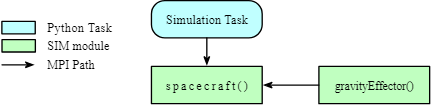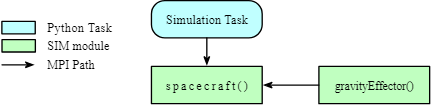

Example shows a spacecraft orbiting a celestial body. These plots collectively illustrate the motion of a spacecraft in orbit, highlighting its position, deviations from a reference trajectory, and orbital path.

![Figure_1](Figures/Figure_1.png)  
First plot represents the trajectory of the spacecraft in inertial space.  
The three curves correspond to the spacecraft's position components in a 3D inertial coordinate frame.  
![Figure_3](Figures/Figure_3.png)  
This plot shows small deviations in the spacecraft's trajectory along the three inertial axes.
These differences are typically the result of numerical errors, perturbations, or other forces acting on the spacecraft.  
![Figure_2](Figures/Figure_2.png)  
The green circle represents the celestial body.
The red line corresponds to the spacecraft's orbit, while the dashed line represent a reference orbit for comparison.

![Figure_1](Figures/Figure_1_GTO.png)
![Figure_3](Figures/Figure_3_GTO.png)
![Figure_2](Figures/Figure_2_GTO.png)

#### Training test with RLlib
Still in Basilisk and Gyb env, but use the PPO algorithm.

In [ ]:
# Initialize a PPO agent
model = PPO(
    policy="MlpPolicy",  # Multi-layer perceptron policy
    env=env,
    verbose=1,
    learning_rate=3e-4,
    n_steps=1024,  # Number of steps per environment per update
    batch_size=64,  # Mini-batch size
    n_epochs=5,  # Number of epochs for optimization
    gamma=0.99,  # Discount factor
    gae_lambda=0.95,  # GAE parameter
    clip_range=0.2,  # PPO clip parameter
    ent_coef=0.01,  # Entropy coefficient for exploration
    device='cpu' # explicitly set cpu usage based on docs
)


In [ ]:
# Train the agent
total_timesteps = 1_000_000  # Adjust based on your needs
model.learn(total_timesteps=total_timesteps)

# Save the trained model
model.save("bsk_rl_ppo_model")

> ### Continue in Draft_2.0